# Исследование надежности заемщиков.

## Описание проекта
Заказчик — кредитный отдел банка. Нужно разобраться, влияет ли семейное положение и количество детей клиента на факт погашения кредита в срок. Входные данные от банка — статистика о платёжеспособности клиентов.
Результаты исследования будут учтены при построении модели кредитного скоринга — специальной системы, которая оценивает способность потенциального заёмщика вернуть кредит банку.

## Описание данных
- children — количество детей в семье
- days_employed — общий трудовой стаж в днях
- dob_years — возраст клиента в годах
- education — уровень образования клиента
- education_id — идентификатор уровня образования
- family_status — семейное положение
- family_status_id — идентификатор семейного положения
- gender — пол клиента
- income_type — тип занятости
- debt — имел ли задолженность по возврату кредитов
- total_income — ежемесячный доход
- purpose — цель получения кредита

### Шаг 1. Обзор данных

In [1]:
import pandas as pd

In [2]:
import seaborn as sns

In [3]:
data = pd.read_csv('/datasets/data.csv')

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
children            21525 non-null int64
days_employed       19351 non-null float64
dob_years           21525 non-null int64
education           21525 non-null object
education_id        21525 non-null int64
family_status       21525 non-null object
family_status_id    21525 non-null int64
gender              21525 non-null object
income_type         21525 non-null object
debt                21525 non-null int64
total_income        19351 non-null float64
purpose             21525 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


In [5]:
data.head()

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,-8437.673028,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья
1,1,-4024.803754,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля
2,0,-5623.422610,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья
3,3,-4124.747207,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование
4,0,340266.072047,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу


### Шаг 2.1 Заполнение пропусков

В столбцах days_employed и total_income есть пропущенные значения.

Определяем общее количество пропусов по столбцам.

In [6]:
sum_nan_days_employed = data['days_employed'].isna().sum()

In [7]:
sum_nan_days_employed

2174

In [8]:
sum_nan_total_income = data['total_income'].isna().sum()

In [9]:
sum_nan_total_income

2174

Определяем какую долю составляют пропущенные значения в каждом из столбцов с пропусками.

In [10]:
ratio_nan_days_employed = sum_nan_days_employed / data.shape[0]

In [11]:
ratio_nan_days_employed

0.10099883855981417

In [12]:
ratio_nan_total_income = sum_nan_total_income / data.shape[0]

In [13]:
ratio_nan_days_employed

0.10099883855981417

Пропущенные значения составляют 0,1 долю от общего количества значений в столбцах

Заполняем пропущенные значения медианой с группировкой по типам занятости. Медиана больше подходит для оценки среднего значения, потому что снижает влияние выбросов.

In [14]:
for income_type in data['income_type'].unique():
    median_days_employed = data.loc[data['income_type'] == income_type, 'days_employed'].median()
    data.loc[(data['days_employed'].isna()) & (data['income_type'] == income_type), 'days_employed'] = median_days_employed

In [15]:
for income_type in data['income_type'].unique():
    median_total_income = data.loc[data['income_type'] == income_type, 'total_income'].median()
    data.loc[(data['total_income'].isna()) & (data['income_type'] == income_type), 'total_income'] = median_total_income

Проверка выполнения замены:

In [16]:
data['total_income'].isna().sum()

0

In [17]:
data['total_income'].isna().sum()

0

In [18]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
children            21525 non-null int64
days_employed       21525 non-null float64
dob_years           21525 non-null int64
education           21525 non-null object
education_id        21525 non-null int64
family_status       21525 non-null object
family_status_id    21525 non-null int64
gender              21525 non-null object
income_type         21525 non-null object
debt                21525 non-null int64
total_income        21525 non-null float64
purpose             21525 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


Пустые значения отсутствуют.

### Шаг 2.2 Проверка данных на аномалии и исправления.

#### Определяем аномалии в столбце 'children':

In [19]:
data['children'].value_counts()

 0     14149
 1      4818
 2      2055
 3       330
 20       76
-1        47
 4        41
 5         9
Name: children, dtype: int64

Значения '-1'и '20' предпожительно, появились из-за опечатки. Преведем замену на значения '1' и '2' соответственно.

In [20]:
data['children'] = data['children'].replace(-1, 1)

In [21]:
data['children'] = data['children'].replace(20, 2)

Проверка проведенной замены

In [22]:
data['children'].value_counts()

0    14149
1     4865
2     2131
3      330
4       41
5        9
Name: children, dtype: int64

#### Определяем аномалии в столбце 'days_employed'. 

In [23]:
data['days_employed']

0         -8437.673028
1         -4024.803754
2         -5623.422610
3         -4124.747207
4        340266.072047
             ...      
21520     -4529.316663
21521    343937.404131
21522     -2113.346888
21523     -3112.481705
21524     -1984.507589
Name: days_employed, Length: 21525, dtype: float64

In [24]:
data['days_employed'].max(), data['days_employed'].min()

(401755.40047533, -18388.949900568383)

Присутствуют отрицательные значения и аномально большие значения количества дней трудового стажа. Скорее всего, потому что применялось две различные системы сбора данных. 

Избавляемся от отрицательных значения, применяя функцию abs(), для получения модуля каждого значения в столбце.

In [25]:
data['days_employed'] = data['days_employed'].abs()

In [26]:
data['days_employed']

0          8437.673028
1          4024.803754
2          5623.422610
3          4124.747207
4        340266.072047
             ...      
21520      4529.316663
21521    343937.404131
21522      2113.346888
21523      3112.481705
21524      1984.507589
Name: days_employed, Length: 21525, dtype: float64

Для наглядности переведём значения столбца из типа данных float64 в тип данных int64.

In [27]:
data['days_employed'] = data['days_employed'].astype('int')

In [28]:
data['days_employed'].max(), data['days_employed'].min()

(401755, 24)

С помощью библиотеки seaborn, построим диаграмму рассеяния для отсортированных значений days_employed.

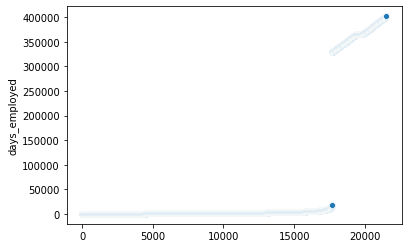

In [29]:
sns.scatterplot(data=data, x=range(len(data)), y=data['days_employed'].sort_values())

На диаграмме видно, что значения days_employed разделены на две группы, с нормальными значениям и аномально высокими. Разделим значения days_employed по этому принципу. Пограничным значением возьмем days_employed = 50000.

In [30]:
abnormal_days_employed = data[data['days_employed'] > 50000]['days_employed']

Аномально высокие значения, скорее всего указаны в часах, а не днях.  Переведем эти значения в дни.

In [31]:
normalized_days_employed = abnormal_days_employed / 24

Добавим исправленные обработанные значения в исходный датафрейм.

In [32]:
data.loc[(data['days_employed'] > 50000), 'days_employed'] = normalized_days_employed.astype(int)

In [33]:
data

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,8437,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья
1,1,4024,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля
2,0,5623,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья
3,3,4124,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование
4,0,14177,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу
...,...,...,...,...,...,...,...,...,...,...,...,...
21520,1,4529,43,среднее,1,гражданский брак,1,F,компаньон,0,224791.862382,операции с жильем
21521,0,14330,67,среднее,1,женат / замужем,0,F,пенсионер,0,155999.806512,сделка с автомобилем
21522,1,2113,38,среднее,1,гражданский брак,1,M,сотрудник,1,89672.561153,недвижимость
21523,3,3112,38,среднее,1,женат / замужем,0,M,сотрудник,1,244093.050500,на покупку своего автомобиля


In [34]:
data['days_employed'].max() , data['days_employed'].min()

(18388, 24)

Переводим максимальное значение days_employed в года, для проверки реальности данных

In [35]:
data['days_employed'].max() / 365

50.37808219178082

Трудовой стаж в 50,4 года вполне возможен.

#### Определяем аномалии в столбце 'dob_years'.

In [36]:
data['dob_years'].value_counts()

35    617
40    609
41    607
34    603
38    598
42    597
33    581
39    573
31    560
36    555
44    547
29    545
30    540
48    538
37    537
50    514
43    513
32    510
49    508
28    503
45    497
27    493
56    487
52    484
47    480
54    479
46    475
58    461
57    460
53    459
51    448
59    444
55    443
26    408
60    377
25    357
61    355
62    352
63    269
64    265
24    264
23    254
65    194
66    183
22    183
67    167
21    111
0     101
68     99
69     85
70     65
71     58
20     51
72     33
19     14
73      8
74      6
75      1
Name: dob_years, dtype: int64

Возраст клиента со значением "0" встречается 101 раз.

Заполняем нулевые значения медианой с группировкой по типам занятости.

In [37]:
for income_type in data['income_type'].unique():
    median_dob_years = data.loc[data['income_type'] == income_type, 'dob_years'].median()
    data.loc[(data['dob_years'] == 0) & (data['income_type'] == income_type), 'dob_years'] = median_dob_years

In [38]:
data['dob_years'] = data['dob_years'].astype('int')

#### Определяем аномалия в столбце 'gender'.

In [39]:
data['gender'].value_counts()

F      14236
M       7288
XNA        1
Name: gender, dtype: int64

Одно неопределенное значение XNA. Удаляем данную строку.

In [40]:
data = data.loc[data['gender'] != 'XNA'].reset_index(drop=True)

In [41]:
data['gender'].value_counts()

F    14236
M     7288
Name: gender, dtype: int64

### Шаг 2.3. Изменение типов данных.

Замена вещественного типа данных в столбце total_income на целочисленный:

In [42]:
data['total_income'] = data['total_income'].astype('int') 

In [43]:
data['total_income'].dtypes

dtype('int64')

Замена вещественного типа данных в столбце стаж days_employed на целочисленный:

In [44]:
 data['days_employed'] = data['days_employed'].astype('int') 

In [45]:
data['days_employed'].dtypes

dtype('int64')

Замена целочисленного типа данных в столбце debt на булевое:

In [46]:
 data['debt'] = data['debt'].astype('bool') 

In [47]:
data['debt'].dtypes

dtype('bool')

### Шаг 2.4. Удаление дубликатов.

Удаление явных строк-дубликатов

In [48]:
data.duplicated().sum()

54

In [49]:
#data = data.drop_duplicates().reset_index(drop=True)

In [50]:
#data.duplicated().sum()

Удаление неявных дубликатов. 

В столбце education:

In [51]:
data['education'].value_counts()

среднее                13750
высшее                  4718
СРЕДНЕЕ                  772
Среднее                  711
неоконченное высшее      667
ВЫСШЕЕ                   274
Высшее                   268
начальное                250
Неоконченное высшее       47
НЕОКОНЧЕННОЕ ВЫСШЕЕ       29
НАЧАЛЬНОЕ                 17
Начальное                 15
ученая степень             4
Ученая степень             1
УЧЕНАЯ СТЕПЕНЬ             1
Name: education, dtype: int64

In [52]:
data['education'] = data['education'].str.lower()

In [53]:
data['education'].value_counts()

среднее                15233
высшее                  5260
неоконченное высшее      743
начальное                282
ученая степень             6
Name: education, dtype: int64

### Шаг 2.5. Формирование дополнительных датафреймов словарей, декомпозиция исходного датафрейма.

In [54]:
df_education = data[['education_id', 'education']]

In [55]:
df_education['education'].value_counts()

среднее                15233
высшее                  5260
неоконченное высшее      743
начальное                282
ученая степень             6
Name: education, dtype: int64

In [56]:
df_family_status = data[['family_status_id', 'family_status']]

In [57]:
df_family_status['family_status'].value_counts()

женат / замужем          12380
гражданский брак          4176
Не женат / не замужем     2813
в разводе                 1195
вдовец / вдова             960
Name: family_status, dtype: int64

Удаление из исходного датафрейма столбцов: education и family_status.

In [58]:
data.duplicated().sum()

71

In [59]:
data = data.drop(['education', 'family_status'], axis=1)

### Шаг 2.6. Категоризация дохода.

Создание столбца total_income_category с категориями по доходам.

Создаем функцию group_total_income для определения категорий:

In [60]:
def group_total_income(income):
    group = ''
    if 0 < income < 30000:
        group = 'E'
    elif 30001 < income < 50000:
        group = 'D'
    elif 50001 < income < 200000:
        group = 'C'
    elif 200001 < income < 1000000:
        group = 'B'
    else:
        group = 'A'
    return group

Для добавления нового столбца применяем метод apply() с аргументом в виде функции group_total_income.

In [61]:
data['total_income_category'] = data['total_income'].apply(group_total_income)

In [62]:
data.head()

,children,days_employed,dob_years,education_id,family_status_id,gender,income_type,debt,total_income,purpose,total_income_category
0,1,8437,42,0,0,F,сотрудник,False,253875,покупка жилья,B
1,1,4024,36,1,0,F,сотрудник,False,112080,приобретение автомобиля,C
2,0,5623,33,1,0,M,сотрудник,False,145885,покупка жилья,C
3,3,4124,32,1,0,M,сотрудник,False,267628,дополнительное образование,B
4,0,14177,53,1,1,F,пенсионер,False,158616,сыграть свадьбу,C


In [63]:
data['total_income_category'].value_counts()

C    16086
B     5040
D      350
A       26
E       22
Name: total_income_category, dtype: int64

### Шаг 2.7. Категоризация целей кредита.

In [64]:
data['purpose'].value_counts()

свадьба                                   797
на проведение свадьбы                     777
сыграть свадьбу                           774
операции с недвижимостью                  676
покупка коммерческой недвижимости         664
покупка жилья для сдачи                   653
операции с жильем                         653
операции с коммерческой недвижимостью     651
покупка жилья                             647
жилье                                     647
покупка жилья для семьи                   641
строительство собственной недвижимости    635
недвижимость                              634
операции со своей недвижимостью           630
строительство жилой недвижимости          626
покупка недвижимости                      623
строительство недвижимости                620
покупка своего жилья                      620
ремонт жилью                              612
покупка жилой недвижимости                607
на покупку своего автомобиля              505
заняться высшим образованием      

In [65]:
def group_purpose(purpose):
    group = ''
    if 'авто' in purpose:
        group = 'операции с автомобилем'
    elif 'недвижим' in purpose:
        group = 'операции с недвижимостью'
    elif 'свадьб' in purpose:
        group = 'проведение свадьбы'
    else:
        group = 'получение образования'
    return group   

In [66]:
data['purpose_category'] = data['purpose'].apply(group_purpose)

In [67]:
data.head()

,children,days_employed,dob_years,education_id,family_status_id,gender,income_type,debt,total_income,purpose,total_income_category,purpose_category
0,1,8437,42,0,0,F,сотрудник,False,253875,покупка жилья,B,получение образования
1,1,4024,36,1,0,F,сотрудник,False,112080,приобретение автомобиля,C,операции с автомобилем
2,0,5623,33,1,0,M,сотрудник,False,145885,покупка жилья,C,получение образования
3,3,4124,32,1,0,M,сотрудник,False,267628,дополнительное образование,B,получение образования
4,0,14177,53,1,1,F,пенсионер,False,158616,сыграть свадьбу,C,проведение свадьбы


In [68]:
def group_children(children):
    group = ''
    if children == 0:
        group = 'нет детей'
    elif 1 <= children < 3:
        group = '1 или 2 ребенка'
    else:
        group = '3 и более детей'
    return group  

In [69]:
data['children_category'] = data['children'].apply(group_children)

In [70]:
data['children_category'].value_counts()

нет детей          14148
1 или 2 ребенка     6996
3 и более детей      380
Name: children_category, dtype: int64

In [71]:
data.duplicated().sum()

71

In [72]:
data = data.drop_duplicates().reset_index(drop=True)

In [73]:
data.duplicated().sum()

0

#### Сводная таблица для определения зависимости между количеством детей и возвратом кредита в срок.

In [74]:
children_pivot_table = data.pivot_table(index='children_category', values='purpose', columns='debt', aggfunc='count').fillna(0)

In [75]:
children_pivot_table.columns = ['Нет задолженности', 'Задолженность']

In [76]:
children_pivot_table['% задолженности'] = children_pivot_table['Задолженность'] / (children_pivot_table['Задолженность'] + 
                                                                                   children_pivot_table['Нет задолженности'])

In [77]:
display(children_pivot_table.style.format({'Нет задолженности' : 
                                           '{:.0f}', 'Задолженность' : '{:.0f}', '% задолженности' : '{:.2%}' }))

,Нет задолженности,Задолженность,% задолженности
children_category,,,
1 или 2 ребенка,6336,647,9.27%
3 и более детей,349,31,8.16%
нет детей,13027,1063,7.54%


#### Сводная таблица для определения зависимости между семейным положением и возвратом кредита в срок.

In [78]:
df_family_status = df_family_status.drop_duplicates()

In [79]:
family_status_pivot_table = data.pivot_table(index='family_status_id', values='purpose', columns='debt', aggfunc='count')

In [80]:
family_status_pivot_table.columns = ['Нет задолженности', 'Задолженность']

In [81]:
family_status_pivot_table['% задолженности'] = family_status_pivot_table['Задолженность'] / (family_status_pivot_table['Задолженность'] + 
                                                                                             family_status_pivot_table['Нет задолженности'])

In [82]:
family_status_pivot_table = df_family_status.merge(family_status_pivot_table, on='family_status_id')

In [83]:
display(family_status_pivot_table.style.format({'Нет задолженности' : 
                                                '{:.0f}', 'Задолженность' : '{:.0f}', '% задолженности' : '{:.2%}' }))

,family_status_id,family_status,Нет задолженности,Задолженность,% задолженности
0,0,женат / замужем,11408,931,7.55%
1,1,гражданский брак,3762,388,9.35%
2,2,вдовец / вдова,896,63,6.57%
3,3,в разводе,1110,85,7.11%
4,4,Не женат / не замужем,2536,274,9.75%


#### Сводная таблица для определения зависимости между уровнем дохода и возвратом кредита в срок.

In [84]:
income_pivot_table = data.pivot_table(index='total_income_category', values='purpose', columns='debt', aggfunc='count')

In [85]:
income_pivot_table.columns = ['Нет задолженности', 'Задолженность']

In [86]:
income_pivot_table['% задолженности'] = income_pivot_table['Задолженность'] / (income_pivot_table['Задолженность'] + 
                                                                               income_pivot_table['Нет задолженности'])

In [87]:
display(income_pivot_table.style.format({'Нет задолженности' : 
                                         '{:.0f}', 'Задолженность' : '{:.0f}', '% задолженности' : '{:.2%}' }))

,Нет задолженности,Задолженность,% задолженности
total_income_category,,,
A,24,2,7.69%
B,4684,356,7.06%
C,14655,1360,8.49%
D,329,21,6.00%
E,20,2,9.09%


#### Сводная таблица для определения зависимости между целью кредита и его возвратом в срок.

In [88]:
purpose_pivot_table = data.pivot_table(index='purpose_category', values='purpose', columns='debt', aggfunc='count')

In [89]:
purpose_pivot_table.columns = ['Нет задолженности', 'Задолженность']

In [90]:
purpose_pivot_table['% задолженности'] = purpose_pivot_table['Задолженность'] / (purpose_pivot_table['Задолженность'] +
                                                                                 purpose_pivot_table['Нет задолженности'])

In [91]:
display(purpose_pivot_table.style.format({'Нет задолженности' : 
                                          '{:.0f}', 'Задолженность' : '{:.0f}', '% задолженности' : '{:.2%}' }))

,Нет задолженности,Задолженность,% задолженности
purpose_category,,,
операции с автомобилем,3903,403,9.36%
операции с недвижимостью,5876,474,7.46%
получение образования,7795,678,8.00%
проведение свадьбы,2138,186,8.00%


### Ответы на вопросы.

##### Вопрос 1:

Есть ли зависимость между количеством детей и возвратом кредита в срок?

##### Вывод 1:

Минимальное процент задолженности у людей, у которых отсутствуют дети (отсутствует дополнительная нагрузка на бюджет). С увеличением количества детей, т.к. увеличиваются траты на содержание детей, процент невозвратов растет. 

##### Вопрос 2:

Есть ли зависимость между семейным положением и возвратом кредита в срок?

##### Вывод 2:

Минимальныцй процент задолженности у категорий: "вдовец / вдова", "в разводе" и "женат / замужем", т.е. у людей которые состоят или состояли официально в браке более высокий уровень надёжности.

##### Вопрос 3:

Есть ли зависимость между уровнем дохода и возвратом кредита в срок?

##### Вывод 3:

Минимальныцй процент задолженности у категории "D" с доходом ниже среднего (от 30000 до 50000). Потому что, они заранее расчитывают бюджет и закладывают выплаты по кредиту в предстаящие расходы, из-за небольшого количества свободных средств. Максимальный процент - с низним доходом категория "E" (менее 30000). У данной категории людей, возможно, не до конца продумана стратегия выплаты кредита и бывает не хватает средств для погашения из-за непревиденных расходов.

##### Вопрос 4:

Как разные цели кредита влияют на его возврат в срок?

##### Вывод 4:

Больше всего задолженностей при возврате кредита, происходит при операциях с автомобилем, меньше всего при операциях с недвижимостью. На получение образования и на проведение свадьбы приходится примерно одиноковое количество невозвратов. Кредиты на недвижимость имеют большую стоимость и  большую продолжительность. Поэтому, при приобретении такого кредита, люди более тщательно рассчитывают свои возможности и более ответственно относятся к выплате.

## Общий вывод:

Исходя из полученных результатов, можно сделать вывод, что наиболее надежными заёмщиками являются люди у которых нет детей, которые состоят или состояли официально в браке, имеют высокие или ниже среднего уровня доходы и используют кредит для операций с недвижимостью.